Données générées : (100, 50, 2) (points, temps, coord)
Époque 0, perte : 7520.2316
Époque 10, perte : 6228.1874
Époque 20, perte : 6231.0678
Époque 30, perte : 6233.6517
Époque 40, perte : 6229.2098


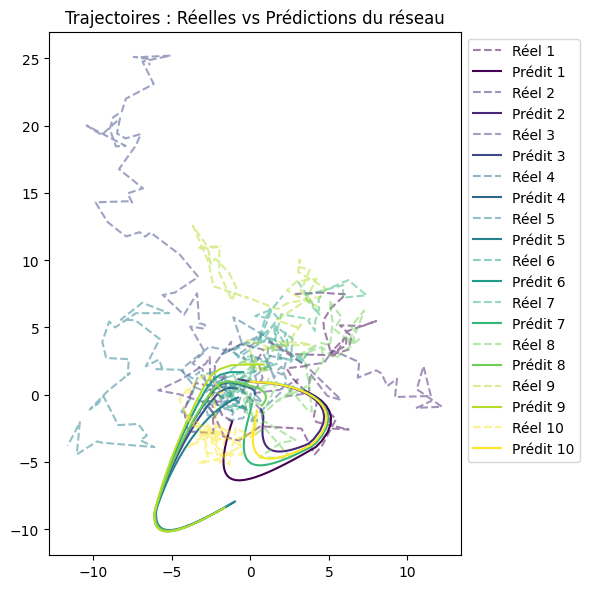

In [1]:
# Cell 1 : Imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Cell 2 : Génération de données (points qui bougent aléatoirement)
def generate_data(n_points=100, seq_len=50):
    data = []
    for _ in range(n_points):
        x = np.cumsum(np.random.randn(seq_len))  # bruit cumulé = mouvement
        y = np.cumsum(np.random.randn(seq_len))
        data.append(np.stack([x, y], axis=1))
    return np.array(data)  # shape: (n_points, seq_len, 2)

data = generate_data()
print(f"Données générées : {data.shape} (points, temps, coord)")

# Cell 3 : Préparation des données pour entraînement
# On prédit la position suivante à partir des positions précédentes
X_train = torch.tensor(data[:, :-1], dtype=torch.float32)  # (n, t-1, 2)
y_train = torch.tensor(data[:, 1:], dtype=torch.float32)   # (n, t-1, 2)

# Cell 4 : Réseau de neurones simple
class MovementPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

model = MovementPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Cell 5 : Entraînement
n_epochs = 50
for epoch in range(n_epochs):
    loss_total = 0
    for i in range(X_train.shape[0]):
        for t in range(X_train.shape[1]):
            inp = X_train[i, t]
            target = y_train[i, t]

            pred = model(inp)
            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_total += loss.item()
    if epoch % 10 == 0:
        print(f"Époque {epoch}, perte : {loss_total:.4f}")

# Cell 6 : Visualisation de l'amélioration (trajectoire prédite vs réelle)
n_display = 10
fig, ax = plt.subplots(figsize=(6, 6))
colors = plt.cm.viridis(np.linspace(0, 1, n_display))

for i in range(n_display):
    real = data[i]
    predicted = [real[0]]

    for t in range(1, real.shape[0]):
        next_pos = model(torch.tensor(predicted[-1], dtype=torch.float32)).detach().numpy()
        predicted.append(next_pos)

    predicted = np.array(predicted)

    ax.plot(real[:, 0], real[:, 1], '--', label=f'Réel {i+1}', alpha=0.5, color=colors[i])
    ax.plot(predicted[:, 0], predicted[:, 1], '-', label=f'Prédit {i+1}', color=colors[i])

ax.set_title("Trajectoires : Réelles vs Prédictions du réseau")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

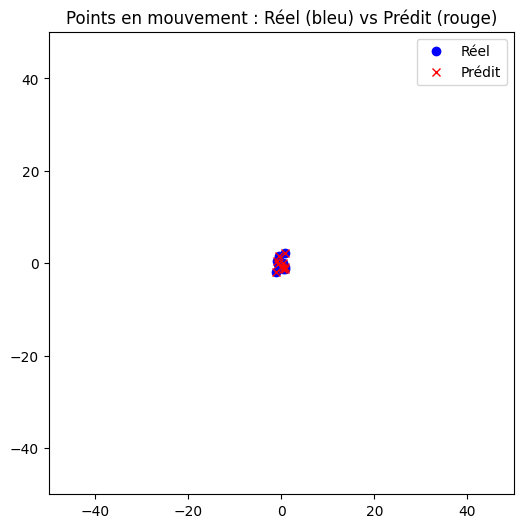

In [3]:
# Cellule : Animation en temps réel des trajectoires

from matplotlib.animation import FuncAnimation

# Paramètres
n_points = 10
seq_len = 50
fig, ax = plt.subplots(figsize=(6, 6))

# Choix des trajectoires
real_paths = data[:n_points]
pred_paths = []

# Générer les trajectoires prédites une fois pour toutes
for i in range(n_points):
    real = real_paths[i]
    predicted = [real[0]]
    for t in range(1, seq_len):
        next_pos = model(torch.tensor(predicted[-1], dtype=torch.float32)).detach().numpy()
        predicted.append(next_pos)
    pred_paths.append(np.array(predicted))

# Initialisation des lignes
real_lines = [ax.plot([], [], 'o', color='blue', label='Réel' if i == 0 else "")[0] for i in range(n_points)]
pred_lines = [ax.plot([], [], 'x', color='red', label='Prédit' if i == 0 else "")[0] for i in range(n_points)]

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_title("Points en mouvement : Réel (bleu) vs Prédit (rouge)")
ax.legend()

# Animation : mise à jour de la position frame par frame
def update(frame):
    for i in range(n_points):
        real_lines[i].set_data([real_paths[i][frame, 0]], [real_paths[i][frame, 1]])
        pred_lines[i].set_data([pred_paths[i][frame, 0]], [pred_paths[i][frame, 1]])
    return real_lines + pred_lines

ani = FuncAnimation(fig, update, frames=seq_len, interval=100, blit=True)
plt.show()

In [4]:
ani.save("trajectoires.mp4", fps=10)